## randomized functions

In [1]:
import numpy as np

In [2]:
def standardize_imgs(imgs):
    assert len(imgs.size()) == 4
    for i in range(imgs.size(0)):
        tmp = imgs[i].view(3, -1)
        tmp_mean = tmp.mean(dim=1).numpy()
        tmp_var = np.maximum(tmp.std(dim=1).numpy(), 1.0 / 28.0 / 28.0)

        imgs[i] = (imgs[i] - torch.FloatTensor(tmp_mean).view(3, 1, 1)) / torch.FloatTensor(tmp_var).view(3,1,1)
    return imgs

## resnet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_base, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = num_base
        self.num_base = num_base
        self.conv1 = nn.Conv2d(3, self.num_base, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_base)
        self.layer1 = self._make_layer(block, self.num_base, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, self.num_base*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, self.num_base*4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, self.num_base*8, num_blocks[3], stride=2)
        self.linear = nn.Linear(self.num_base*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_base):
    return ResNet(BasicBlock, [2,2,2,2], num_base)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


## import cifar 10 dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
transform = transforms.Compose(
    [transforms.CenterCrop(28),
     transforms.ToTensor()
     ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
pixel_mode = "true_pixel"
label_mode = "true_label"

criterion = nn.CrossEntropyLoss()

def train(epoch, starting_step, optimizer):
    # print("\nepoch %d" %epoch)
    
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(trainloader):
        imgs = standardize_imgs(imgs)
            
        logits = net(imgs)
        step_loss = criterion(logits, labels)
        optimizer.zero_grad()
        step_loss.backward()
        optimizer.step()       
        
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += len(labels)
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        total_loss += step_loss.data[0]
#         step_acc = step_corrects * 1. / batch_size
#         if (starting_step + i) % 1000 == 0: 
#             print("step %d, train_acc %f, train_loss %f" %(starting_step + i, step_acc, step_loss.data[0]))
#             test(starting_step + i)
    
    train_acc = total_corrects * 1. / total_samples
            
    return  starting_step + i, train_acc, total_loss

def test():
  
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(testloader):
        imgs = standardize_imgs(imgs)
        
        logits = net(imgs)
        step_loss = criterion(logits, labels)
             
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += len(labels)
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        
        total_loss += step_loss.data[0]

    total_acc = total_corrects * 1.0 / total_samples
    total_loss = total_loss  / total_samples   
        
    print("test_acc %f, test_loss %f" %(total_acc, total_loss))
    return total_acc, total_loss

        
    

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

use_cuda = True
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

exp_dicts = {}
for nb in [1,2,4,8,16,32,48,64,80,96,112,128]:
    exp_dict = {}
    net = ResNet18(nb)
    if use_cuda: net = net.cuda()
    print('nb_param:', count_parameters(net))
    optimizer = optim.Adam(net.parameters(),lr=0.01)
    
    starting_step = 0 
    for epoch in range(30):
        total_step, train_acc, train_loss = train(epoch, starting_step, optimizer)
        print("epoch %d, train_acc %f, train_loss %f" %(epoch, train_acc, train_loss))
        if train_acc == 1.0 or train_loss == 0.0:
            break
        starting_step  = total_step + 1
    
    test_acc, test_loss = test()
    exp_dict['train_acc'] = train_acc
    exp_dict['train_loss'] = train_loss
    exp_dict['test_acc'] = test_acc
    exp_dict['test_loss'] = test_loss
    exp_dicts[count_parameters(net)] = exp_dict
    

nb_param: 2991
epoch 0, train_acc 0.296380, train_loss 2984.576414
epoch 1, train_acc 0.378600, train_loss 2681.963973
epoch 2, train_acc 0.414480, train_loss 2537.375907
epoch 3, train_acc 0.431520, train_loss 2456.498570
epoch 4, train_acc 0.446500, train_loss 2399.985705
epoch 5, train_acc 0.455800, train_loss 2359.550416
epoch 6, train_acc 0.465060, train_loss 2320.060000
epoch 7, train_acc 0.475480, train_loss 2287.981271
epoch 8, train_acc 0.486500, train_loss 2260.892377
epoch 9, train_acc 0.485100, train_loss 2249.399766
epoch 10, train_acc 0.492140, train_loss 2226.246620
epoch 11, train_acc 0.496560, train_loss 2208.465682
epoch 12, train_acc 0.500080, train_loss 2194.447950
epoch 13, train_acc 0.499940, train_loss 2187.166205
epoch 14, train_acc 0.506760, train_loss 2172.541280
epoch 15, train_acc 0.509620, train_loss 2161.786534
epoch 16, train_acc 0.507760, train_loss 2152.567541
epoch 17, train_acc 0.512140, train_loss 2147.842165
epoch 18, train_acc 0.512860, train_loss 

epoch 2, train_acc 0.735580, train_loss 1182.493858
epoch 3, train_acc 0.790340, train_loss 944.533428
epoch 4, train_acc 0.831180, train_loss 761.111278
epoch 5, train_acc 0.866460, train_loss 598.079213
epoch 6, train_acc 0.894300, train_loss 465.511782
epoch 7, train_acc 0.920020, train_loss 353.089723
epoch 8, train_acc 0.936380, train_loss 281.565367
epoch 9, train_acc 0.949860, train_loss 225.045864
epoch 10, train_acc 0.955340, train_loss 199.316538
epoch 11, train_acc 0.962900, train_loss 166.700987
epoch 12, train_acc 0.966800, train_loss 151.660670
epoch 13, train_acc 0.967780, train_loss 144.454911
epoch 14, train_acc 0.971520, train_loss 127.418501
epoch 15, train_acc 0.971680, train_loss 127.674099
epoch 16, train_acc 0.975020, train_loss 110.020371
epoch 17, train_acc 0.975740, train_loss 112.172094
epoch 18, train_acc 0.977300, train_loss 102.395860
epoch 19, train_acc 0.978400, train_loss 98.747949
epoch 20, train_acc 0.979400, train_loss 94.752823
epoch 21, train_acc 0

epoch 7, train_acc 0.954900, train_loss 203.455032
epoch 8, train_acc 0.964320, train_loss 163.386804
epoch 9, train_acc 0.971840, train_loss 129.080657
epoch 10, train_acc 0.971700, train_loss 129.198889
epoch 11, train_acc 0.975880, train_loss 109.234299
epoch 12, train_acc 0.978240, train_loss 98.198543
epoch 13, train_acc 0.978820, train_loss 98.663054
epoch 14, train_acc 0.981160, train_loss 85.198429
epoch 15, train_acc 0.982020, train_loss 85.339835
epoch 16, train_acc 0.982860, train_loss 79.126426
epoch 17, train_acc 0.984700, train_loss 71.351751
epoch 18, train_acc 0.983140, train_loss 78.214973
epoch 19, train_acc 0.984940, train_loss 69.053914
epoch 20, train_acc 0.986560, train_loss 64.267150
epoch 21, train_acc 0.985200, train_loss 69.450270
epoch 22, train_acc 0.987480, train_loss 59.953008
epoch 23, train_acc 0.987120, train_loss 61.623072
epoch 24, train_acc 0.987120, train_loss 59.357788
epoch 25, train_acc 0.988460, train_loss 55.500075
epoch 26, train_acc 0.988440,

In [8]:
print(exp_dicts)

{2991: {'train_acc': 0.5265, 'train_loss': 2088.852639436722, 'test_acc': 0.4357, 'test_loss': 0.40249026946127414}, 11420: {'train_acc': 0.68686, 'train_loss': 1395.398687362671, 'test_acc': 0.5485, 'test_loss': 0.3306081742659211}, 44622: {'train_acc': 0.8443, 'train_loss': 671.3111042305827, 'test_acc': 0.6291, 'test_loss': 0.32359375794902445}, 176402: {'train_acc': 0.95594, 'train_loss': 192.92951936461031, 'test_acc': 0.6844, 'test_loss': 0.4064175593821332}, 701466: {'train_acc': 0.97914, 'train_loss': 95.32571334787644, 'test_acc': 0.712, 'test_loss': 0.42753420520052315}, 2797610: {'train_acc': 0.98486, 'train_loss': 72.30144702037796, 'test_acc': 0.7527, 'test_loss': 0.3748982794923708}, 6288442: {'train_acc': 0.98774, 'train_loss': 56.40384088945575, 'test_acc': 0.7491, 'test_loss': 0.4090780237264931}, 11173962: {'train_acc': 0.98808, 'train_loss': 56.39505666634068, 'test_acc': 0.7612, 'test_loss': 0.35938308416120707}, 17454170: {'train_acc': 0.98872, 'train_loss': 54.274

In [9]:
np.save('exps.npy', exp_dicts)

In [20]:
exp_dicts = np.load('exps.npy').item()
x_value = []
y_value_train_error = []
y_value_train_loss = []
y_value_test_error = []
y_value_test_loss = []
for key in exp_dicts.keys():
    exp_dicts[key]['train_loss'] = exp_dicts[key]['train_loss'] * 1. / 50000
    x_value.append(key)
    y_value_train_error.append(1.0-exp_dicts[key]['train_acc'])
    y_value_train_loss.append(exp_dicts[key]['train_loss'])
    y_value_test_error.append(1.0-exp_dicts[key]['test_acc'])
    y_value_test_loss.append(exp_dicts[key]['test_loss'])

print(x_value)

[2991, 11420, 44622, 176402, 701466, 2797610, 6288442, 11173962, 17454170, 25129066, 34198650, 44662922]


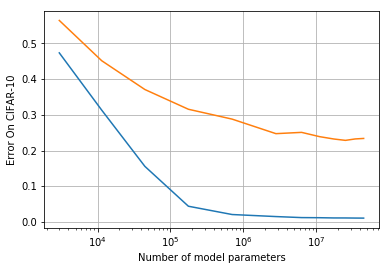

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.semilogx(x_value, y_value_train_error)
plt.semilogx(x_value, y_value_test_error)

plt.xlabel('Number of model parameters')
plt.ylabel('Error On CIFAR-10')
plt.grid(True)
#plt.savefig("test.png")
plt.show()

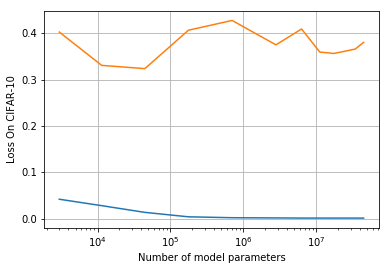

In [24]:
plt.semilogx(x_value, y_value_train_loss)
plt.semilogx(x_value, y_value_test_loss)

plt.xlabel('Number of model parameters')
plt.ylabel('Loss On CIFAR-10')
plt.grid(True)
#plt.savefig("test.png")
plt.show()